In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch
from policy import DPAgent
from datetime import datetime
from pytz import timezone

from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_sample
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [2]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [3]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 20000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.4, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = np.array([0.12450167, 0.40850869, 0.43930126, 0.71356037]) # context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [4]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0005  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'duration_lambda': 10.0,
    'interarrival_lambda': 5.0,
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    'num_iterations': 1, # Number of training iterations per policy update
    'dataset_size': 50000,      # Number of transitions to generate for the offline dataset
    'batch_size': 256           # Batch size for training
}

policy_type = 'decaying_epsilon_greedy'
policy_kwargs = {
    'current_epsilon': 0.20,
    'decay_rate': 0.95,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    discrete_dp=False,  ####################################################
    training_hyperparams=training_hyperparams,
    policy_kwargs=policy_kwargs,
    policy_update_threshold=100,
    time_normalize=True,
)

### Run this if you want to skip Projected Volume part

In [ ]:
# simulator.degradation_learner.theta = 
simulator.projected_volume_learner.centroids.append(UTILITY_TRUE)

degradation_learner = DegradationLearner(d=simulator.d)
degradation_learner.theta = context_sampler()
degradation_learner.cum_baseline = lambda x: LAMBDA_VAL * x
degradation_learner.inverse_cum_baseline = lambda y: y / LAMBDA_VAL
simulator.degradation_learner = degradation_learner

dp_agent = DPAgent(
    d=simulator.d,
    u_hat=UTILITY_TRUE,
    time_normalize=simulator.time_normalize,
    degradation_learner=simulator.degradation_learner,
    customer_generator=simulator.customer_generator,
    params=simulator.mdp_params
)
dp_agent.train(**simulator.training_hyperparams)
simulator.dp_agent = dp_agent
simulator.optimal_policy = dp_agent.get_policy(simulator.policy_type)
simulator.breakdowns_since_last_update = 0 # Reset the counter

simulator.projected_volume_learner.is_terminated = True
simulator.seen_breakdowns = 2

In [ ]:
# get current time in "YYYYMMDD_HHMMSS" in pacific time
pacific_tz = timezone('America/Los_Angeles')
current_time = datetime.now(pacific_tz).strftime("%Y%m%d_%H%M%S")

In [ ]:
# (degradation_df[degradation_df.event == 1][[f"X{i}" for i in range(D)]].to_numpy() @ THETA_TRUE).max()

In [ ]:
# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()

degradation_df.to_csv(f'data/degradation_data_{current_time}.csv', index=False)
simulation_df.to_csv(f'data/simulation_data_{current_time}.csv', index=False)
simulator.save(f'models/simulator_{current_time}')

INFO:root:Starting simulation for 20000 customers...
  0%|          | 0/20000 [00:00<?, ?it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.51141D+04    |proj g|=  1.00000D+00

At iterate    1    f=  1.37118D+04    |proj g|=  6.81740D-01

At iterate    2    f=  1.36937D+04    |proj g|=  6.50590D-01

At iterate    3    f=  1.36718D+04    |proj g|=  5.25812D-01

At iterate    4    f=  1.36628D+04    |proj g|=  5.38727D-01

At iterate    5    f=  1.36624D+04    |proj g|=  7.02088D-01

At iterate    6    f=  1.36624D+04    |proj g|=  7.01577D-01

At iterate    7    f=  1.36624D+04    |proj g|=  7.00917D-01

At iterate    8    f=  1.36624D+04    |proj g|=  2.04538D-01

At iterate    9    f=  1.36624D+04    |proj g|=  2.22184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

INFO:root:Theta updated. New theta_hat: [0.54  0.132 0.408 0.3  ]


Using device: mps
Generating 50000 experience samples...


### Convergence of $\hat\theta$

In [ ]:
simulator.theta_updates

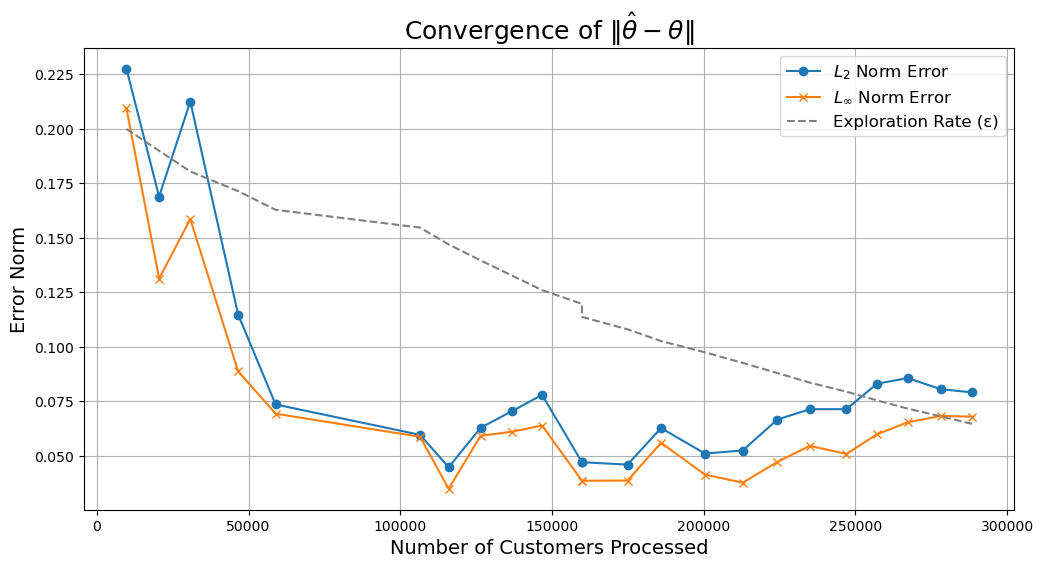

In [13]:
# simulator = Simulator.load('models/simulator_0914')

history = pd.DataFrame(simulator.history)
degradation_history = pd.DataFrame(simulator.degradation_history)

epsilons = [0.20 * (0.95 ** i) for i in range(len(simulator.theta_updates))]

times = []

for d in simulator.theta_updates:
    idx, theta_hat = d['customer_idx'], d['theta_hat']
    time = history[history.customer_id == idx]['calendar_time'].max()
    times.append(time)
    
# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE) for update in simulator.theta_updates]
Linf_errors = [np.linalg.norm(update['theta_hat'] - THETA_TRUE, ord=np.inf) for update in simulator.theta_updates]

plt.figure(figsize=(12, 6))
plt.plot(times, L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(times, Linf_errors, label='$L_\infty$ Norm Error', marker='x')
plt.plot(times, epsilons, label='Exploration Rate (ε)', linestyle='--', color='gray')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat{\\theta} - \\theta\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Convergence of $\hat u$

In [ ]:
simulator.utility_updates

# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE) for update in simulator.utility_updates]
Linf_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE, ord=np.inf) for update in simulator.utility_updates]

plt.figure(figsize=(12, 6))
plt.plot(L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat u - u\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

### Revenue of Online Learner

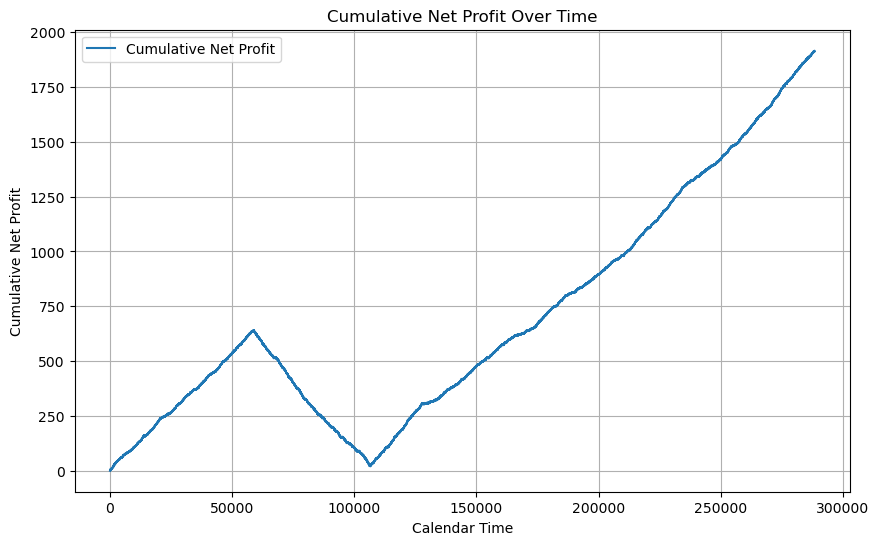

In [14]:
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()

ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(simulation_df['calendar_time'], simulation_df['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.savefig('figures/cumulative_net_profit_online.pdf')
plt.show()

## Training policy under perfect information

### Revenue of Optimal Policy

Think about how mnay failures are met at ~5000 customers

-> how accurate that theta hat would be

-> how much we should be steering policy to pick argmax Q

-> use that decay rate to test optimal policy and see if it is still positive

In [17]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)

perfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()

perfect_dpagent.train(
    num_iterations=1,
    dataset_size=200000,
    batch_size=256
)

perfect_policy = perfect_dpagent.get_policy('greedy')

"""
Use last estimated theta from the simulator
"""

imperfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=simulator.theta_updates[-1]['theta_hat'],
    hazard_model=usage_exp_hazard_model,
)

imperfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=imperfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()

imperfect_dpagent.train(
    num_iterations=1,
    dataset_size=200000,
    batch_size=256
)

imperfect_policy = imperfect_dpagent.get_policy('greedy')

Using device: mps
Generating 200000 experience samples...


100%|██████████| 200000/200000 [00:01<00:00, 117217.15it/s]



Starting FQI training loop...


100%|██████████| 1/1 [00:39<00:00, 39.56s/it]



Training complete.
Using device: mps
Generating 200000 experience samples...


100%|██████████| 200000/200000 [00:01<00:00, 116380.02it/s]



Starting FQI training loop...


100%|██████████| 1/1 [00:37<00:00, 37.80s/it]


Training complete.


In [19]:
simulation_df = pd.DataFrame(simulator.history)

samples = simulator.run_full_exploit(20000, perfect_policy, {'tau': 0.01})
samples = pd.DataFrame(samples)

imperfect_samples = simulator.run_full_exploit(20000, imperfect_policy, {'tau': 0.01})
imperfect_samples = pd.DataFrame(imperfect_samples)

simulation_df['net_profit'] = simulation_df['profit'] + simulation_df['loss']
simulation_df['cumulative_net_profit'] = simulation_df['net_profit'].cumsum()
samples['net_profit'] = samples['profit'] + samples['loss']
samples['cumulative_net_profit'] = samples['net_profit'].cumsum()
imperfect_samples['net_profit'] = imperfect_samples['profit'] + imperfect_samples['loss']
imperfect_samples['cumulative_net_profit'] = imperfect_samples['net_profit'].cumsum()

samples['netprofit_per_time'] = samples['cumulative_net_profit'] / samples['calendar_time']
imperfect_samples['netprofit_per_time'] = imperfect_samples['cumulative_net_profit'] / imperfect_samples['calendar_time']
simulation_df['netprofit_per_time'] = simulation_df['cumulative_net_profit'] / simulation_df['calendar_time']

INFO:root:Starting simulation for 20000 customers...
100%|██████████| 20000/20000 [00:15<00:00, 1253.11it/s]
INFO:root:Simulation finished.
INFO:root:Starting simulation for 20000 customers...
100%|██████████| 20000/20000 [00:15<00:00, 1304.97it/s]
INFO:root:Simulation finished.


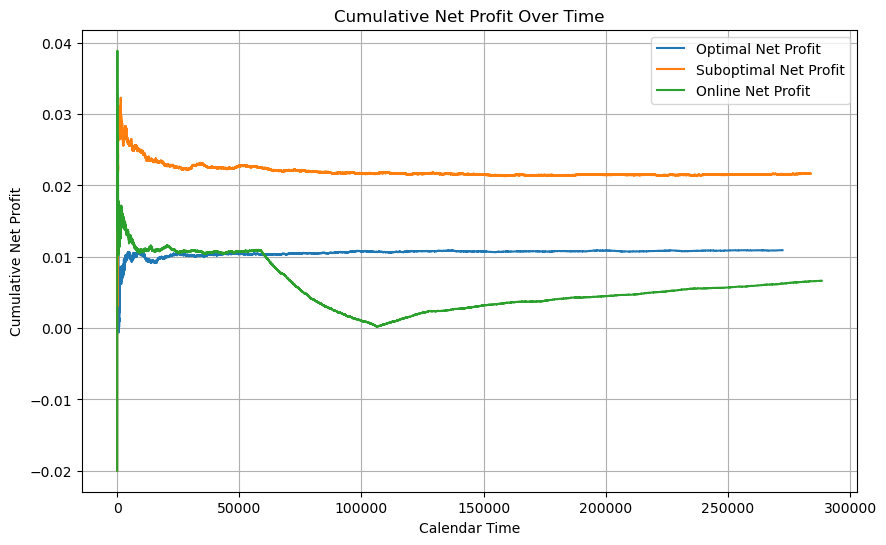

In [20]:

ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(samples['calendar_time'], samples['netprofit_per_time'], label='Optimal Net Profit')
plt.plot(imperfect_samples['calendar_time'], imperfect_samples['netprofit_per_time'], label='Suboptimal Net Profit')
plt.plot(simulation_df['calendar_time'], simulation_df['netprofit_per_time'], label='Online Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()